In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from glob import glob
import os
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns


df_train = pd.read_csv("./data/train_set.csv")


df_test = pd.read_csv("./data/test_set.csv")

df_train.head()

,Historical Period,height,diam,width,depth,num_period,medium_num,classif_num,culture_num
0,Antiquity,7.1,-1.0,10.8,-1.0,4.0,3.046062,2.533376,2.136866
1,Antiquity,-1.0,3.7,-1.0,-1.0,4.0,3.046062,3.998735,4.000000
2,Antiquity,2.9,-1.0,9.2,-1.0,4.0,3.875496,3.993417,3.905965
3,Antiquity,2.7,-1.0,2.2,-1.0,4.0,3.046062,2.533376,3.301802
4,Antiquity,-1.0,-1.0,-1.0,-1.0,4.0,3.119048,2.533376,3.841270


In [2]:
df_train.iloc[20000,:]

Historical Period    Contemporary Era
height                          241.9
diam                             -1.0
width                           117.5
depth                            -1.0
num_period                        1.0
medium_num                   1.728041
classif_num                  2.153191
culture_num                  2.136866
Name: 20000, dtype: object

### Preprocessing

#### Get X and y

In [3]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

periods_train = np.array(df_train["Historical Period"]).reshape(-1, 1)

ohe = OneHotEncoder(sparse=False)
ohe.fit(periods_train)
y_ohe_train = ohe.transform(periods_train)

periods_test = np.array(df_test["Historical Period"]).reshape(-1, 1)
y_ohe_test = ohe.transform(periods_test)
y_ohe_train

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [4]:
import numpy as np
y_train = np.array(df_train["num_period"])
y_train

array([4., 4., 4., ..., 2., 2., 2.])

In [5]:
X_train = np.array(df_train.drop(columns=["Historical Period", "num_period"]))
X_train.shape

(40180, 7)

In [6]:
y_test = np.array(df_test["num_period"])
X_test = np.array(df_test.drop(columns=["Historical Period", "num_period"]))

In [7]:
dico_map_ohe = {}

for i,val in enumerate(y_test):
  if val not in dico_map_ohe.keys():
    dico_map_ohe[val] = np.argmax(y_ohe_test[i,:])
  if len(dico_map_ohe)==4:
    break

In [8]:
dico_map_ohe

{4.0: 0, 1.0: 1, 3.0: 2, 2.0: 3}

In [9]:
y_train_ = [dico_map_ohe[target] for target in y_train]
y_test_ = [dico_map_ohe[target] for target in y_test]

#### Rescaling the features

medium_num, culture_num and classif_num are bounded between 1 and 4 by construction (fine).


Let's transform the features related to dimensions: height, width, depth and diam. It doesn't really make sense (from a physical point of view) to normalize them to zero mean and unit variance. Instead, let's rescale them so that they are between 0 and 1:

In [10]:
X_train[0,:]

array([ 7.1       , -1.        , 10.8       , -1.        ,  3.04606152,
        2.53337623,  2.13686557])

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train[:,:4])
dims_train_minmax = scaler.transform(X_train[:,:4])

In [12]:
print(np.min(dims_train_minmax, axis=0), np.max(dims_train_minmax, axis=0))

[0. 0. 0. 0.] [1. 1. 1. 1.]


In [13]:
X_train[:,:4] = dims_train_minmax
print(X_train[0,:])

[0.00339836 0.         0.00640886 0.         3.04606152 2.53337623
 2.13686557]


In [14]:
# apply the same transformation on testing set
dims_test_minmax = scaler.transform(X_test[:,:4])
X_test[:,:4] = dims_test_minmax
X_test[0,:]

array([0.        , 0.00655793, 0.        , 0.        , 2.93310463,
       3.05988515, 2.96666667])

### Deep learning architectures

MLP

In [16]:
num_features = X_train.shape[1]
num_classes = 4

mlp_baseline = Sequential()
mlp_baseline.add(Dense(10, activation='relu'))
mlp_baseline.add(Dense(num_classes, activation = 'softmax'))

In [17]:
mlp_baseline.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])
mlp_baseline.fit(X_train, y_ohe_train, epochs=5)

Epoch 1/5
1256/1256 [==============================] - 3s 2ms/step - loss: 1.1956 - accuracy: 0.4216: 
Epoch 2/5
1256/1256 [==============================] - 2s 2ms/step - loss: 0.8901 - accuracy: 0.5869
Epoch 3/5
1256/1256 [==============================] - 2s 2ms/step - loss: 0.7945 - accuracy: 0.6665
Epoch 4/5
1256/1256 [==============================] - 3s 2ms/step - loss: 0.7567 - accuracy: 0.6939
Epoch 5/5
1256/1256 [==============================] - 2s 2ms/step - loss: 0.7382 - accuracy: 0.6966


In [18]:
mlp_baseline.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                80        
                                                                 
 dense_1 (Dense)             (None, 4)                 44        
                                                                 
Total params: 124
Trainable params: 124
Non-trainable params: 0
_________________________________________________________________


In [19]:
def plot_confusion_matrix(model, X_test, y_test, model_name=""):
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns

    #preds = model.predict(X_test)
    preds = np.argmax(model.predict(X_test), axis=1) # adapt to softmax
    conf_mat = confusion_matrix(y_test, preds)
    plt.figure(figsize=(8,8))
    sns.heatmap(conf_mat, cmap="Blues",
    annot=True,
    )
    plt.title("Confusion matrix of {}".format(model_name))
    plt.xlabel("Predicted class")
    plt.ylabel("True class")
    plt.show()

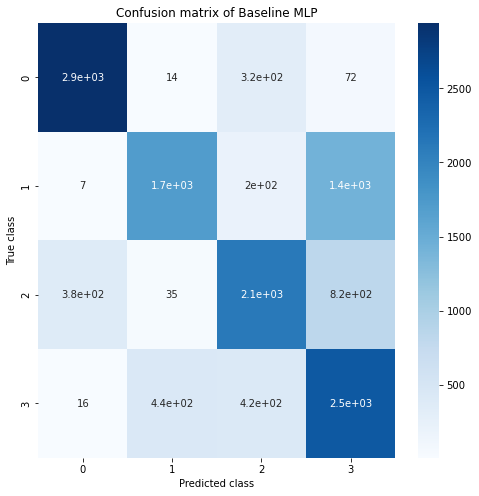

In [20]:
plot_confusion_matrix(mlp_baseline, X_test, y_test=y_test_, model_name="Baseline MLP")

In [21]:
#from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

accuracy_score(y_test_, np.argmax(mlp_baseline.predict(X_test), axis=1))

0.6898327859062406

In [22]:
accuracy_score(y_train_, np.argmax(mlp_baseline.predict(X_train), axis=1))

0.6958685913389746

### Test other models

In [23]:
tf.random.set_seed(1)
model = Sequential()
model.add(Dense(500, activation='relu'))
model.add(Dense(300, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(num_classes, activation = 'softmax'))

In [24]:
model.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, y_ohe_train, epochs=5)

Epoch 1/5
1256/1256 [==============================] - 6s 4ms/step - loss: 0.7641 - accuracy: 0.6680
Epoch 2/5
1256/1256 [==============================] - 5s 4ms/step - loss: 0.6511 - accuracy: 0.7260
Epoch 3/5
1256/1256 [==============================] - 7s 5ms/step - loss: 0.6338 - accuracy: 0.7347
Epoch 4/5
1256/1256 [==============================] - 6s 5ms/step - loss: 0.6236 - accuracy: 0.7426
Epoch 5/5
1256/1256 [==============================] - 6s 5ms/step - loss: 0.6172 - accuracy: 0.7456


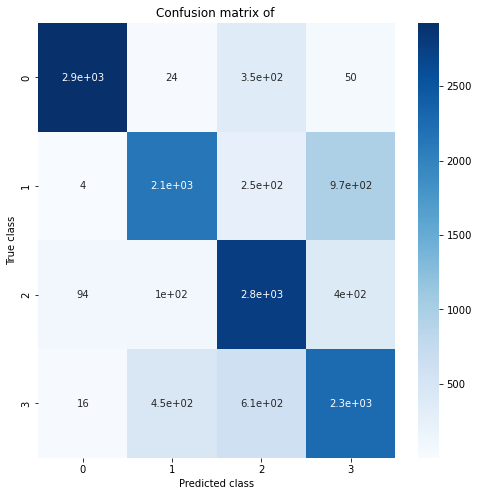

In [25]:
plot_confusion_matrix(model, X_test, y_test=y_test_)

In [26]:
accuracy_score(y_train_, np.argmax(model.predict(X_train), axis=1))

0.7587356893977103

In [27]:
accuracy_score(y_test_, np.argmax(model.predict(X_test), axis=1))

0.7520155270229919

In [28]:
Acc_train = []
Acc_test = []
for i in range (10):
    tf.random.set_seed(1)
    model = Sequential()
    model.add(Dense(500, activation='relu'))
    model.add(Dense(300, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(i/10))
    model.add(Dense(num_classes, activation = 'softmax'))
    model.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])
    model.fit(X_train, y_ohe_train, epochs=5, verbose=False)
    #plot_confusion_matrix(model, X_test, y_test=y_test_)
    Acc_test.append(accuracy_score(y_test_, np.argmax(model.predict(X_test), axis=1)))
    Acc_train.append(accuracy_score(y_train_, np.argmax(model.predict(X_train), axis=1)))

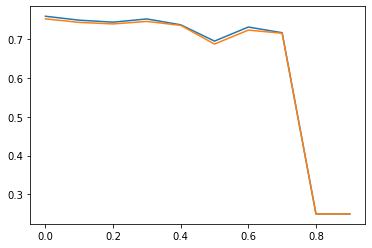

In [29]:
x = np.arange(10)
plt.plot(x/10,Acc_train)
plt.plot(x/10,Acc_test)

### Influence of the number of hidden layers

In [31]:
def mlp_depending_num_hidden_layers(n_hidden_layers, num_classes):
    mlp_baseline = Sequential()
    for i in range(n_hidden_layers):
        mlp_baseline.add(Dense(10, activation='relu'))
    mlp_baseline.add(Dense(num_classes, activation = 'softmax'))
    mlp_baseline.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])
    mlp_baseline.fit(X_train, y_ohe_train, epochs=10, verbose=False)
    score = mlp_baseline.evaluate(X_test, y_ohe_test, verbose=False)
    return score[1]


In [34]:
import random
random.seed(42)

num_hidden_layers : 1
num_hidden_layers : 2
num_hidden_layers : 3
num_hidden_layers : 4
num_hidden_layers : 5
num_hidden_layers : 6
num_hidden_layers : 7
num_hidden_layers : 8
num_hidden_layers : 9
num_hidden_layers : 10


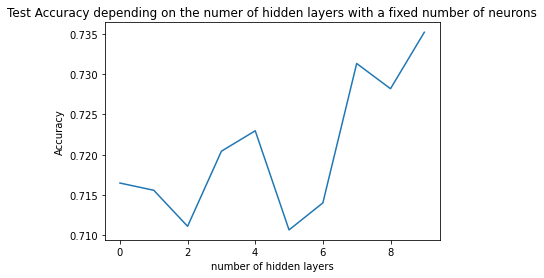

In [37]:
accuracy = []
for i in range(1,11):
  acc = mlp_depending_num_hidden_layers(n_hidden_layers=i, num_classes=4)
  accuracy.append(acc)
  print(f'num_hidden_layers : {i}')

plt.plot(accuracy)
plt.xlabel("number of hidden layers")
plt.ylabel("Accuracy")
plt.title("Test Accuracy depending on the numer of hidden layers with a fixed number of neurons")
plt.show()

In each hidden layers, we consider 10 neurons.
We see clearly that the accuracy on the test set is better with a number of hidden layer of 10. We don't have a global evolution of the performance with the the number of hidden layer

Let's take the best model, and build a confusion matrix

In [38]:
num_classes = 4

best_model = Sequential()
for i in range(1,11):
  best_model.add(Dense(10, activation='relu'))

best_model.add(Dense(num_classes, activation = 'softmax'))


best_model.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

best_model.fit(X_train, y_ohe_train, epochs=10)

Epoch 1/10
1256/1256 [==============================] - 4s 2ms/step - loss: 0.8142 - accuracy: 0.6319
Epoch 2/10
1256/1256 [==============================] - 3s 2ms/step - loss: 0.7026 - accuracy: 0.6990
Epoch 3/10
1256/1256 [==============================] - 3s 2ms/step - loss: 0.6824 - accuracy: 0.7099
Epoch 4/10
1256/1256 [==============================] - 3s 2ms/step - loss: 0.6734 - accuracy: 0.7130
Epoch 5/10
1256/1256 [==============================] - 3s 3ms/step - loss: 0.6666 - accuracy: 0.7196
Epoch 6/10
1256/1256 [==============================] - 3s 2ms/step - loss: 0.6616 - accuracy: 0.7204
Epoch 7/10
1256/1256 [==============================] - 3s 2ms/step - loss: 0.6594 - accuracy: 0.7219
Epoch 8/10
1256/1256 [==============================] - 3s 2ms/step - loss: 0.6542 - accuracy: 0.7250
Epoch 9/10
1256/1256 [==============================] - 4s 3ms/step - loss: 0.6480 - accuracy: 0.7261: 0s - loss: 0.6476 - accura
Epoch 10/10
1256/1256 [==============================]

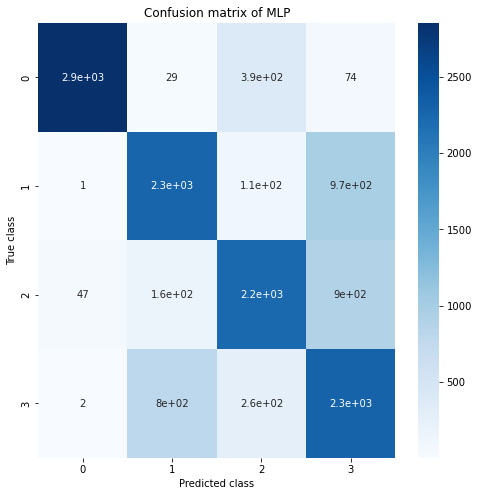

In [39]:
plot_confusion_matrix(best_model, X_test, y_test=y_test_, model_name="MLP")

## $\textbf{Impact of the optimizer parametrization on performances of MLP}$

In [40]:
from tensorflow.keras import optimizers

dir(optimizers)

['Adadelta',
 'Adagrad',
 'Adam',
 'Adamax',
 'Ftrl',
 'Nadam',
 'Optimizer',
 'RMSprop',
 'SGD',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_sys',
 'deserialize',
 'get',
 'schedules',
 'serialize']

In [41]:
optimizers_available = [r for r in dir(optimizers) if r[0].isupper()]
optimizers_available

['Adadelta',
 'Adagrad',
 'Adam',
 'Adamax',
 'Ftrl',
 'Nadam',
 'Optimizer',
 'RMSprop',
 'SGD']

In [51]:
def mlp(optimizer="adam", lr=1e-3):
    assert(optimizer in optimizers_available)
    num_features = X_train.shape[1]
    num_classes = 4

    mlp = Sequential()
    mlp.add(Dense(20, activation='relu'))
    mlp.add(Dense(num_classes, activation='softmax'))
    mlp.compile(optimizer=eval("optimizers.{}(learning_rate={})".format(optimizer, lr)),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    return mlp

In [49]:
learning_rates = [10**i for i in range(-8,2,1)]
learning_rates

[1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10]

### $\textbf{Learning rate impact on Adam}$

In [52]:
from sklearn.metrics import accuracy_score
train_accs_adam = []
test_accs_adam = []

for lr in learning_rates:
  mlp_tmp = mlp(optimizer="Adam", lr=lr)
  mlp_tmp.fit(X_train, y_ohe_train, epochs=10, verbose=False)
  train_acc = accuracy_score(y_train_, np.argmax(mlp_tmp.predict(X_train), axis=1))
  test_acc = accuracy_score(y_test_, np.argmax(mlp_tmp.predict(X_test), axis=1))
  train_accs_adam.append(train_acc)
  test_accs_adam.append(test_acc)

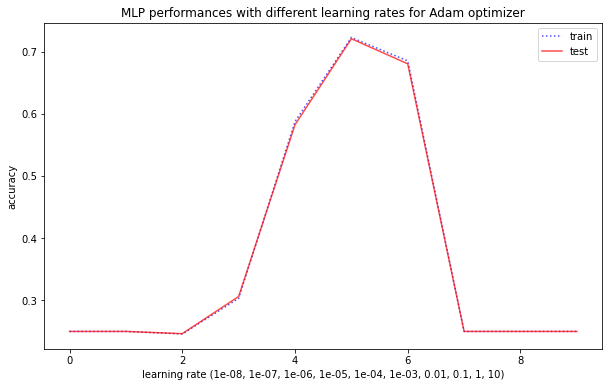

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(train_accs_adam, label="train", color="blue", alpha=0.7, linestyle=":")
plt.plot(test_accs_adam, label="test", color="red", alpha=0.7)
plt.legend()
plt.xlabel("learning rate (1e-08, 1e-07, 1e-06, 1e-05, 1e-04, 1e-03, 0.01, 0.1, 1, 10)")
plt.ylabel("accuracy")
plt.title("MLP performances with different learning rates for Adam optimizer")
plt.show()

### $\textbf{Learning rate impact on SGD}$

In [55]:
train_accs_sgd = []
test_accs_sgd = []

for lr in learning_rates:
  mlp_tmp = mlp(optimizer="SGD", lr=lr)
  mlp_tmp.fit(X_train, y_ohe_train, epochs=10, verbose=False)
  train_acc = accuracy_score(y_train_, np.argmax(mlp_tmp.predict(X_train), axis=1))
  test_acc = accuracy_score(y_test_, np.argmax(mlp_tmp.predict(X_test), axis=1))
  train_accs_sgd.append(train_acc)
  test_accs_sgd.append(test_acc)

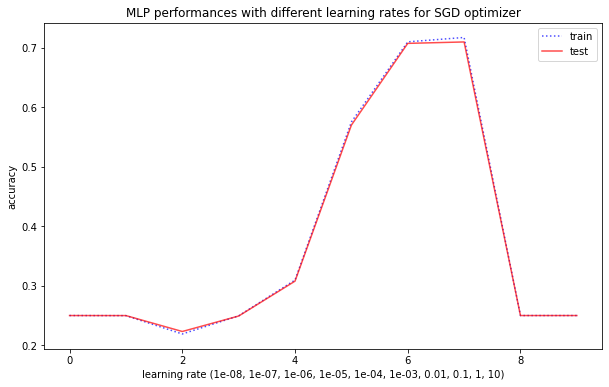

In [56]:
plt.figure(figsize=(10,6))
plt.plot(train_accs_sgd, label="train", color="blue", alpha=0.7, linestyle=":")
plt.plot(test_accs_sgd, label="test", color="red", alpha=0.7)
plt.legend()
plt.xlabel("learning rate (1e-08, 1e-07, 1e-06, 1e-05, 1e-04, 1e-03, 0.01, 0.1, 1, 10)")
plt.ylabel("accuracy")
plt.title("MLP performances with different learning rates for SGD optimizer")
plt.show()

### $\textbf{Learning rate impact on Adagrad}$

In [57]:
train_accs_adagrad = []
test_accs_adagrad = []

for lr in learning_rates:
  mlp_tmp = mlp(optimizer="Adagrad", lr=lr)
  mlp_tmp.fit(X_train, y_ohe_train, epochs=10, verbose=False)
  train_acc = accuracy_score(y_train_, np.argmax(mlp_tmp.predict(X_train), axis=1))
  test_acc = accuracy_score(y_test_, np.argmax(mlp_tmp.predict(X_test), axis=1))
  train_accs_adagrad.append(train_acc)
  test_accs_adagrad.append(test_acc)

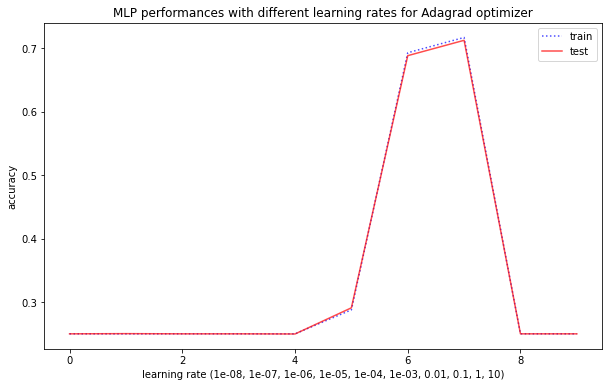

In [58]:
plt.figure(figsize=(10,6))
plt.plot(train_accs_adagrad, label="train", color="blue", alpha=0.7, linestyle=":")
plt.plot(test_accs_adagrad, label="test", color="red", alpha=0.7)
plt.legend()
plt.xlabel("learning rate (1e-08, 1e-07, 1e-06, 1e-05, 1e-04, 1e-03, 0.01, 0.1, 1, 10)")
plt.ylabel("accuracy")
plt.title("MLP performances with different learning rates for Adagrad optimizer")
plt.show()

### $\textbf{Learning rate impact on Adamax}$

In [59]:
train_accs_adamax = []
test_accs_adamax = []

for lr in learning_rates:
  mlp_tmp = mlp(optimizer="Adamax", lr=lr)
  mlp_tmp.fit(X_train, y_ohe_train, epochs=10, verbose=False)
  train_acc = accuracy_score(y_train_, np.argmax(mlp_tmp.predict(X_train), axis=1))
  test_acc = accuracy_score(y_test_, np.argmax(mlp_tmp.predict(X_test), axis=1))
  train_accs_adamax.append(train_acc)
  test_accs_adamax.append(test_acc)

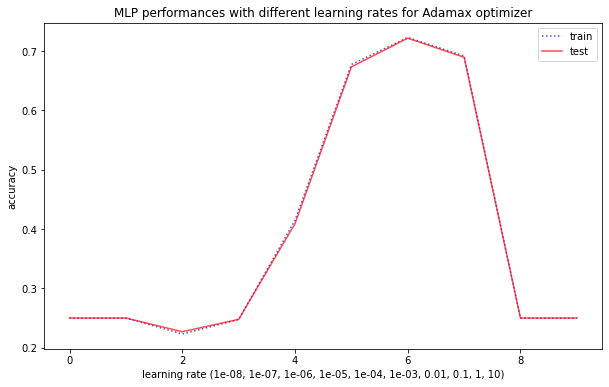

In [60]:
plt.figure(figsize=(10,6))
plt.plot(train_accs_adamax, label="train", color="blue", alpha=0.7, linestyle=":")
plt.plot(test_accs_adamax, label="test", color="red", alpha=0.7)
plt.legend()
plt.xlabel("learning rate (1e-08, 1e-07, 1e-06, 1e-05, 1e-04, 1e-03, 0.01, 0.1, 1, 10)")
plt.ylabel("accuracy")
plt.title("MLP performances with different learning rates for Adamax optimizer")
plt.show()

### $\textbf{Find the best optimizer}$


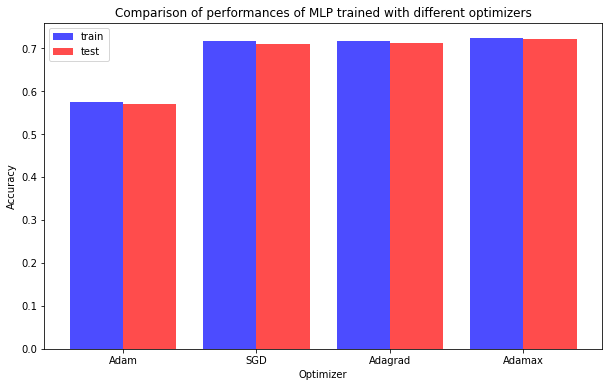

In [61]:
import numpy as np 
import matplotlib.pyplot as plt 

X = ['Adam','SGD','Adagrad', 'Adamax']

args = [np.argmax(test_accs_adam), np.argmax(test_accs_sgd), np.argmax(test_accs_adagrad), np.argmax(test_accs_adamax)]
train_accs = [train_accs_sgd[args[0]], train_accs_sgd[args[1]], train_accs_adagrad[args[2]], train_accs_adamax[args[3]]]
test_accs = [test_accs_sgd[args[0]], test_accs_sgd[args[1]], test_accs_adagrad[args[2]], test_accs_adamax[args[3]]]
  
X_axis = np.arange(len(X))

plt.figure(figsize=(10,6))
plt.bar(X_axis - 0.2, train_accs, 0.4, label = 'train', color="blue", alpha=0.7)
plt.bar(X_axis + 0.2, test_accs, 0.4, label = 'test', color="red", alpha=0.7)
  
plt.xticks(X_axis, X)
plt.xlabel("Optimizer")
plt.ylabel("Accuracy")
plt.title("Comparison of performances of MLP trained with different optimizers")
plt.legend()
plt.show()

In [62]:
args

[5, 7, 7, 6]

In [63]:
learning_rates[7]

0.1

In [64]:
test_accs_adamax[7]

0.6895341893102419

In [65]:
mlp_best = mlp(optimizer="Adamax", lr=learning_rates[7])
mlp_best.fit(X_train, y_ohe_train, epochs=10)

Epoch 1/10
1256/1256 [==============================] - 5s 3ms/step - loss: 0.7779 - accuracy: 0.6574
Epoch 2/10
1256/1256 [==============================] - 3s 2ms/step - loss: 0.7010 - accuracy: 0.6990
Epoch 3/10
1256/1256 [==============================] - 3s 2ms/step - loss: 0.6856 - accuracy: 0.7057
Epoch 4/10
1256/1256 [==============================] - 2s 2ms/step - loss: 0.6784 - accuracy: 0.7073
Epoch 5/10
1256/1256 [==============================] - 3s 2ms/step - loss: 0.6702 - accuracy: 0.7162
Epoch 6/10
1256/1256 [==============================] - 2s 2ms/step - loss: 0.6696 - accuracy: 0.7149: 0s
Epoch 7/10
1256/1256 [==============================] - 2s 2ms/step - loss: 0.6654 - accuracy: 0.7229
Epoch 8/10
1256/1256 [==============================] - 2s 2ms/step - loss: 0.6610 - accuracy: 0.7256
Epoch 9/10
1256/1256 [==============================] - 2s 2ms/step - loss: 0.6593 - accuracy: 0.7248
Epoch 10/10
1256/1256 [==============================] - 3s 2ms/step - loss: 0

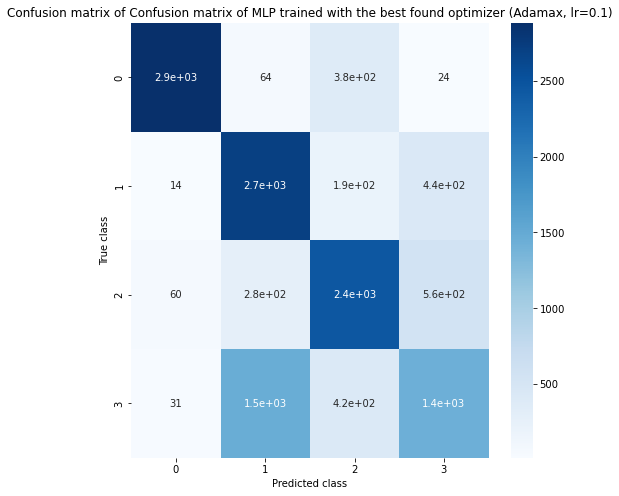

In [66]:
plot_confusion_matrix(mlp_best, X_test, y_test=y_test_, model_name="Confusion matrix of MLP trained with the best found optimizer (Adamax, lr=0.1)")